# Train a Diffusion Mode with ü§ó Diffusers

## Ïù¥ ÌååÏùºÏóêÏÑú ÌïôÏäµÌï† ÎÇ¥Ïö©

- PoC(Proof of Concept)Î•º ÏúÑÌïú Í∞ÑÎã®Ìïú Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± Î™®Îç∏ÏùÑ  MNISTÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Î∞ëÎ∞îÎã•Î∂ÄÌÑ∞ ÌïôÏäµ

- ü§ó DiffusersÏóêÏÑú Ï†úÍ≥µÌïòÎäî UNet2D Î™®Îç∏ Ïã¨Ï∏µ Î∂ÑÏÑù




## Step 1: Setup

- Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌïòÏó¨ ÎîîÌì®Ï†Ä ÎùºÏù¥Î∏åÎü¨Î¶¨ÏôÄ Î™á Í∞ÄÏßÄ Îã§Î•∏ ÏöîÍµ¨ ÏÇ¨Ìï≠ÏùÑ ÏÑ§Ïπò

In [2]:
# !pip install -qU diffusers

In [3]:
import diffusers

diffusers.__version__

'0.31.0'

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

- ÎîîÎ∞îÏù¥Ïä§ ÏÑ∏ÌåÖ

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Step 2: Prepare a training dataset

- pytorchÎ°ú Î∂ÄÌÑ∞ MNISTÎç∞Ïù¥ÌÑ∞ ÏÖã Îã§Ïö¥Î°úÎìú

- Ïù¥ÎØ∏ÏßÄ Î∞∞ÏπòÎ•º Í∑∏Î¶¨Îìú ÌòïÌÉúÎ°ú Î∞îÍøî ÌëúÏãúÌï† Î≥¥Ï°∞ Ìï®Ïàò Ï†ïÏùò

In [6]:
def show_images(x, return_type='PIL'):
    """Given a batch of images x, make a grid and convert to PIL"""

    # Map from (-1, 1) back to (0, 1)
    x = x * 0.5 + 0.5

    # (B x C x H x W) -> (C x H x W)Ïù∏ Ïù¥ÎØ∏ÏßÄÎ•º (B/nrow, nrow)Ïù∏ Í≤©ÏûêÌòïÌÉúÎ°ú.
    # Default nrow: 8
    # 1Ï±ÑÎÑê Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûÖÎ†•ÎêòÎèÑ Î∞òÌôòÏùÄ 3Ï±ÑÎÑêÎ°ú Îê®
    grid = torchvision.utils.make_grid(x)

    #                             ch last,         (0,1) -> (0,255)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255

    if return_type == 'PIL':
        # PIL Ïù¥ÎØ∏ÏßÄÎ°ú Î¶¨ÌÑ¥ÌïòÎäî Í≤ΩÏö∞
        # tensor -> ndarray -> Image
        grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    else:
        # numpy Ïñ¥Î†àÏù¥Î°ú Î¶¨ÌÑ¥ÌïòÎäî Í≤ΩÏö∞
        # tensor -> ndarray
        # ndarray(H,W,C)
        grid_im = np.array(grid_im).astype(np.uint8)

    return grid_im

In [7]:
from torchvision import transforms

image_size = 28
batch_size = 128

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [8]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True,
    transform=preprocess)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9.91M/9.91M [00:00<00:00, 50.9MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 28.9k/28.9k [00:00<00:00, 1.66MB/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.65M/1.65M [00:00<00:00, 12.9MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.54k/4.54k [00:00<00:00, 1.95MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [9]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([1, 1, 5, 8, 9, 3, 5, 7, 6, 5, 0, 4, 2, 4, 6, 9, 2, 1, 5, 8, 7, 0, 1, 9,
        5, 7, 2, 0, 8, 8, 7, 2, 8, 7, 8, 6, 7, 1, 2, 2, 9, 6, 0, 3, 5, 3, 1, 6,
        3, 4, 0, 0, 3, 2, 0, 2, 4, 6, 9, 6, 0, 3, 0, 3, 2, 7, 7, 4, 6, 3, 7, 3,
        7, 0, 4, 6, 0, 7, 9, 1, 6, 2, 0, 2, 8, 7, 1, 1, 5, 4, 4, 1, 7, 6, 9, 3,
        5, 7, 4, 0, 4, 5, 4, 0, 0, 6, 6, 6, 8, 4, 9, 3, 1, 5, 5, 2, 9, 3, 4, 7,
        4, 8, 7, 8, 7, 5, 7, 7])
<class 'PIL.Image.Image'>


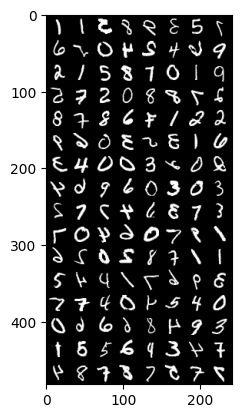

In [10]:
x, y = next(iter(train_dataloader))

print('Input shape:', x.shape)
print('Labels:', y)

grid_imgs = show_images(x)
print(type(grid_imgs))

plt.imshow(grid_imgs)

plt.show()

## Step 3: Define the Scheduler

- Diffusion Î™®Îç∏Ïùò ÌïôÏäµÏùÄ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏóê ÎÖ∏Ïù¥Ï¶àÎ•º Ï∂îÍ∞ÄÌïú Îã§Ïùå ÎÖ∏Ïù¥Ï¶à Ïù¥ÎØ∏ÏßÄÎ•º Î™®Îç∏Ïóê Í≥µÍ∏âÌïòÍ≥† Ïù¥ÎØ∏ÏßÄÏóê Ï∂îÍ∞ÄÎêú ÎÖ∏Ïù¥Ï¶àÎ•º ÏòàÏ∏°ÌïòÎäî Í≥ºÏ†ï

- Îî∞ÎùºÏÑú Ïñ¥Îñ§ Ïä§ÏºÄÏ•¥Î°ú ÎÖ∏Ïù¥Ï¶àÎ•º Ï∂îÍ∞ÄÌïòÎäîÏßÄÎèÑ Î™®Îç∏Ïùò ÌïôÏäµÏóê ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ®

- DDPM([Denoising Diffusion Probabalistic Models](https://arxiv.org/abs/2006.11239))ÏóêÏÑú Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî ÎÖ∏Ïù¥Ï¶à Ïä§ÏºÄÏ•¥Îü¨Î•º ÏÑ∏ÌåÖ

In [11]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

X shape: torch.Size([8, 1, 28, 28])


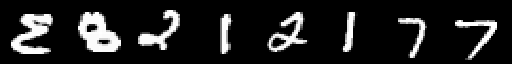

In [12]:
xb = next(iter(train_dataloader))[0].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

timesteps:  tensor([ 59, 790,  89, 340, 100,  90, 940, 890], device='cuda:0')
Noisy X shape torch.Size([8, 1, 28, 28])


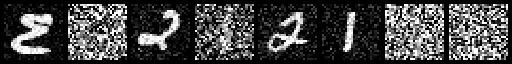

In [13]:
timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (8,)
        ).long().to(device)
print('timesteps: ', timesteps)

noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Step 4: Define the Model

- ÎÖ∏Ïù¥Ï¶à Ï†úÍ±∞ Î™®Îç∏ÏùÑ ÏßÅÏ†ë ÎßåÎì§ÏßÄ ÏïäÍ≥† ü§ó DiffusersÏóêÏÑú Ï†úÍ≥µÌïòÎäî ÏïÑÎûòÏôÄ Í∞ôÏùÄ Í∞ÄÏû• Í∞ÑÎã®Ìïú ÌòïÌÉúÏùò UNet Î™®Îç∏ÏùÑ ÏÉùÏÑ±
    - Î™®Îç∏ÏùÄ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÍ∞Ä ResNet Î†àÏù¥Ïñ¥Ïùò Ïó¨Îü¨ Î∏îÎ°ùÏùÑ Í±∞ÏπòÎèÑÎ°ù ÌïòÍ≥† Í∞Å Î∏îÎ°ùÏùÄ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º 2Î°ú Î∞òÏúºÎ°ú Ï§ÑÏûÑ
    - Í∑∏Îü∞ Îã§Ïùå Îã§Ïãú ÏóÖÏÉòÌîåÎßÅÌïòÎäî ÎèôÏùºÌïú ÏàòÏùò Î∏îÎ°ùÏùÑ ÌÜµÌï¥ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º ÏõêÎ≥µ
    - Ïù¥Îïå Îã§Ïö¥ ÏÉòÌîå Î∏îÎ°ùÏùò ÌîºÏ≤òÎ•º ÏóÖÏÉòÌîå Î∏îÏóê Ïó∞Í≤∞ÌïòÎäî Ïä§ÌÇµ Ïó∞Í≤∞ Ï°¥Ïû¨
    - Î™®Îç∏Ïùò ÏµúÏ¢Ö ÏòàÏ∏°ÏùÄ ÏûÖÎ†•Í≥º ÎèôÏùºÌïú ÌÅ¨Í∏∞Ïùò Ïù¥ÎØ∏ÏßÄ

- Î™®Îç∏ ÎÇ¥Î∂ÄÏóê self attentionÏù¥ Ï∂îÍ∞ÄÎêòÍ≥† skip connectionÎèÑ Ï°¥Ïû¨ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê ÏôÑÏ†ÑÌûà ÌååÏïÖÌïòÍ∏∞ Ïñ¥Î†§ÏõÄ

- Ï†úÍ≥µÎêú Î∂ÑÏÑù Ïä¨ÎùºÏù¥Îìú Ï∞∏Í≥†

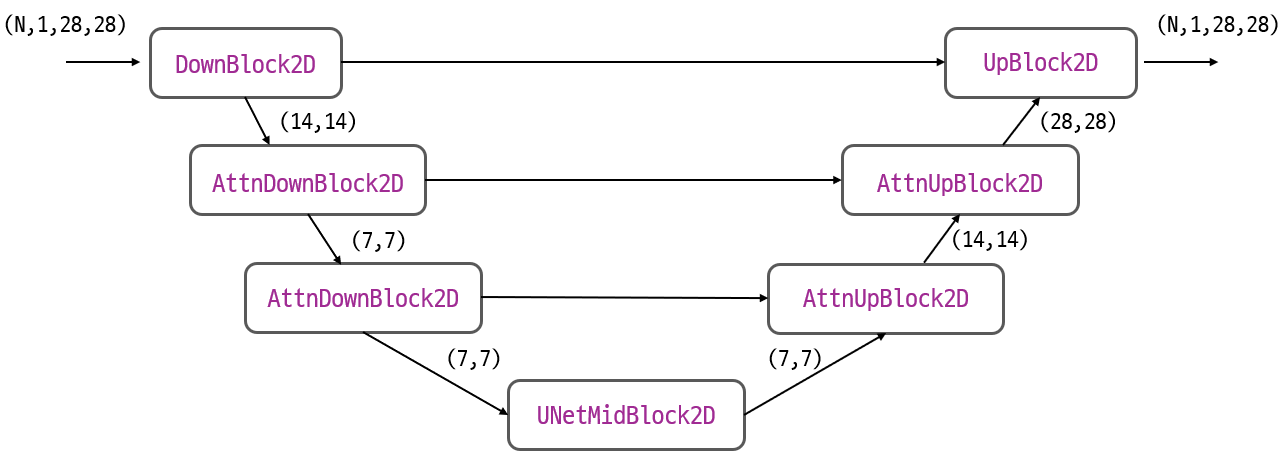

In [14]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,   # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
model.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

### Parameter Í∞úÏàò

In [15]:
sum([p.numel() for p in model.parameters()])

1707009

### Forward Test

- ÏúÑÏóêÏÑú ÎßåÎì† ÎÖ∏Ïù¥Ï¶àÎ°ú Î≠âÍ∞úÏßÑ 8Í∞ú Ïù¥ÎØ∏ÏßÄ `noisy_xb`Î•º ÏûÖÎ†•ÌïòÎ©¥ Í∞Å Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú ÏòàÏ∏° ÎÖ∏Ïù¥Ï¶àÍ∞Ä Î∞òÌôò

- Î∞òÌöê ÌÖêÏÑú ÌÅ¨Í∏∞Í∞Ä `(8,1,28,28)`ÏûÑÏùÑ ÌôïÏù∏


In [16]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample

model_prediction.shape

torch.Size([8, 1, 28, 28])

## Step 5: Create a Training Loop

- Î™®Îç∏Í≥º Ïä§ÏºÄÏ•¥Îü¨Í∞Ä ÏûàÏùÑ Îøê ÌïôÏäµÏùÄ ÏùºÎ∞òÏ†ÅÏù∏ pytorch ÌïôÏäµ Î£®ÌîÑÏôÄ ÎèôÏùº

- Îã® Î™®Îç∏Ïóê ÏÉòÌîå ÎØ∏ÎãàÎ∞∞ÏπòÎ•º ÏûÖÎ†•ÌïòÍ∏∞Ï†ÑÏóê ÎØ∏ÎãàÎ∞∞ÏπòÏóê ÎÖ∏Ïù¥Ï¶àÎ•º Ï£ºÏûÖÌïòÎäî Í≥ºÏ†ïÏùÑ Ï∂îÍ∞Ä

In [17]:
# Training loop
# optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 15
losses = []
print_epoch = 1

for epoch in range(epochs):
    for step, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        # sample images without noise
        clean_images = batch[0].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        #  0 ~ 999 ÌÉÄÏûÖ Ïä§ÌÉ≠ Ïà´Ïûê bsÍ∞ú ÏÉòÌîåÎßÅ
        # Í∞Å Ïù¥ÎØ∏ÏßÄÏóê Í∞ÅÍ∏∞ Îã§Î•∏ ÌÉÄÏûÖÏä§ÌÉ≠ÏùÑ ÏßÄÏ†ïÌïòÏó¨ Í∑∏Ïóê Îî∞Î•∏ ÎÖ∏Ïù¥Ï¶àÎ•º Ï§ÄÎã§.
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps).sample

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()

    if (epoch + 1) % print_epoch == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:1, loss: 0.06694193402015323


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:2, loss: 0.03729273563524935


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:3, loss: 0.033401161579212656


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:4, loss: 0.031102250181217945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:5, loss: 0.029725020477321864


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:6, loss: 0.02801620626230357


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:7, loss: 0.027678823662496833


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:8, loss: 0.0268726241407491


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:9, loss: 0.026092046359454644


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:10, loss: 0.02571835858957854


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:11, loss: 0.02548308027530911


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:12, loss: 0.025001302099367705


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:13, loss: 0.02492009059611414


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:14, loss: 0.024582463683985444


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:15, loss: 0.02435166732286975


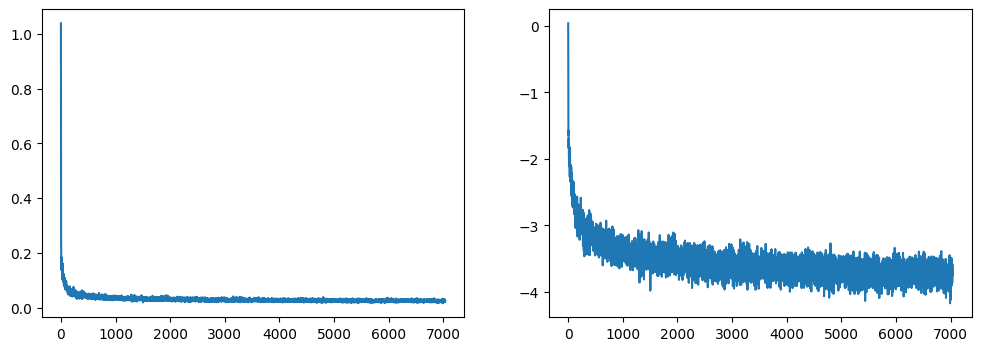

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

- ÌïôÏäµÎêú Î™®Îç∏Î°úÎ∂ÄÌÑ∞ Ïù¥ÎØ∏ÏßÄÎ•º ÏñªÍ∏∞ ÏúÑÌï¥ÏÑú ÎëêÍ∞ÄÏßÄ ÏÑ†ÌÉù Ï°¥Ïû¨

- Option 1ÏùÄ ÌïôÏäµÎêú Î™®Îç∏Í≥º Ïä§ÏºÄÏ•¥Îü¨Î•º `DDPMPipeline` ÌååÏù¥Î∏åÎùºÏù∏Ïóê Í≥µÍ∏âÌïòÍ≥† ÌååÏù¥ÌîÑÎùºÏù∏ÏùÑ Ïã§ÌñâÌïòÏó¨ Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±

### Option 1: Creating a pipeline:

In [19]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [20]:
pipeline_output = image_pipe()
pipeline_output.images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Option 2: Writing a Sampling Loop

- ÎëêÎ≤àÏß∏ Î∞©ÏãùÏùÄ ÏßÅÏ†ë ÏÉòÌîåÎßÅ Î£®ÌîÑÎ•º Íµ¨ÌòÑ


  0%|          | 0/1000 [00:00<?, ?it/s]

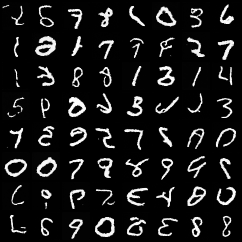

In [22]:
# Random starting point (64 random images):
sample = torch.randn(64, 1, 28, 28).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    # prev_sample: x_{t-1}
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [ ]:
# 2024.11.14 t4ÏóêÏÑú ÌÖåÏä§Ìä∏ ÏôÑÎ£å

# Ïù¥ ÌååÏùº Ïù¥ÌõÑÏóê ÎÇòÎπÑ Îç∞Ïù¥ÌÑ∞ ÌïôÏäµ Ïã§Ïäµ